In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'

In [2]:
def exp_form(x):
    return f'{abs(x):.2f} * exp({np.angle(x)/np.pi:.2f} * pi)'

def kn0(beams:np.array, shift_powers:np.array=None) -> tuple[complex, np.array, dict[np.array]]:

    N1a = beams[0] * np.exp(1j*shift_powers[0]*np.pi) + beams[1] * np.exp(1j*shift_powers[1]*np.pi)
    N1b = beams[0] * np.exp(1j*shift_powers[0]*np.pi) - beams[1] * np.exp(1j*shift_powers[1]*np.pi)
    N2a = beams[2] * np.exp(1j*shift_powers[2]*np.pi) + beams[3] * np.exp(1j*shift_powers[3]*np.pi)
    N2b = beams[2] * np.exp(1j*shift_powers[2]*np.pi) - beams[3] * np.exp(1j*shift_powers[3]*np.pi)

    N3a = N1a * np.exp(1j*shift_powers[4]*np.pi) + N2a * np.exp(1j*shift_powers[6]*np.pi)
    N3b = N1a * np.exp(1j*shift_powers[4]*np.pi) - N2a * np.exp(1j*shift_powers[6]*np.pi)
    N4a = N1b * np.exp(1j*shift_powers[5]*np.pi) + N2b * np.exp(1j*shift_powers[7]*np.pi)
    N4b = N1b * np.exp(1j*shift_powers[5]*np.pi) - N2b * np.exp(1j*shift_powers[7]*np.pi)

    S1a = N3b * np.exp(1j*(shift_powers[8]*np.pi+np.pi/4)) + N4a * np.exp(1j*(shift_powers[10]*np.pi-np.pi/4))
    S1b = N3b * np.exp(1j*(shift_powers[8]*np.pi-np.pi/4)) + N4a * np.exp(1j*(shift_powers[10]*np.pi+np.pi/4))
    S2a = N3b * np.exp(1j*(shift_powers[9]*np.pi+np.pi/4)) + N4b * np.exp(1j*(shift_powers[12]*np.pi-np.pi/4))
    S2b = N3b * np.exp(1j*(shift_powers[9]*np.pi-np.pi/4)) + N4b * np.exp(1j*(shift_powers[12]*np.pi+np.pi/4))
    S3a = N4a * np.exp(1j*(shift_powers[11]*np.pi+np.pi/4)) + N4b * np.exp(1j*(shift_powers[13]*np.pi-np.pi/4))
    S3b = N4a * np.exp(1j*(shift_powers[11]*np.pi-np.pi/4)) + N4b * np.exp(1j*(shift_powers[13]*np.pi+np.pi/4))

    return N3a, [S1a, S1b, S2a, S2b, S3a, S3b], {"first_nuller_layer":[N1a, N1b, N2a, N2b],"second_nuller_layer":[N3a, N3b, N4a, N4b]}

In [3]:
star_light = np.array([
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
], dtype=complex)

planet_light = np.array([
    np.exp(1j * 0.10),
    np.exp(1j * -0.12),
    np.exp(1j * 0.05),
    np.exp(1j * -0.01),
], dtype=complex)

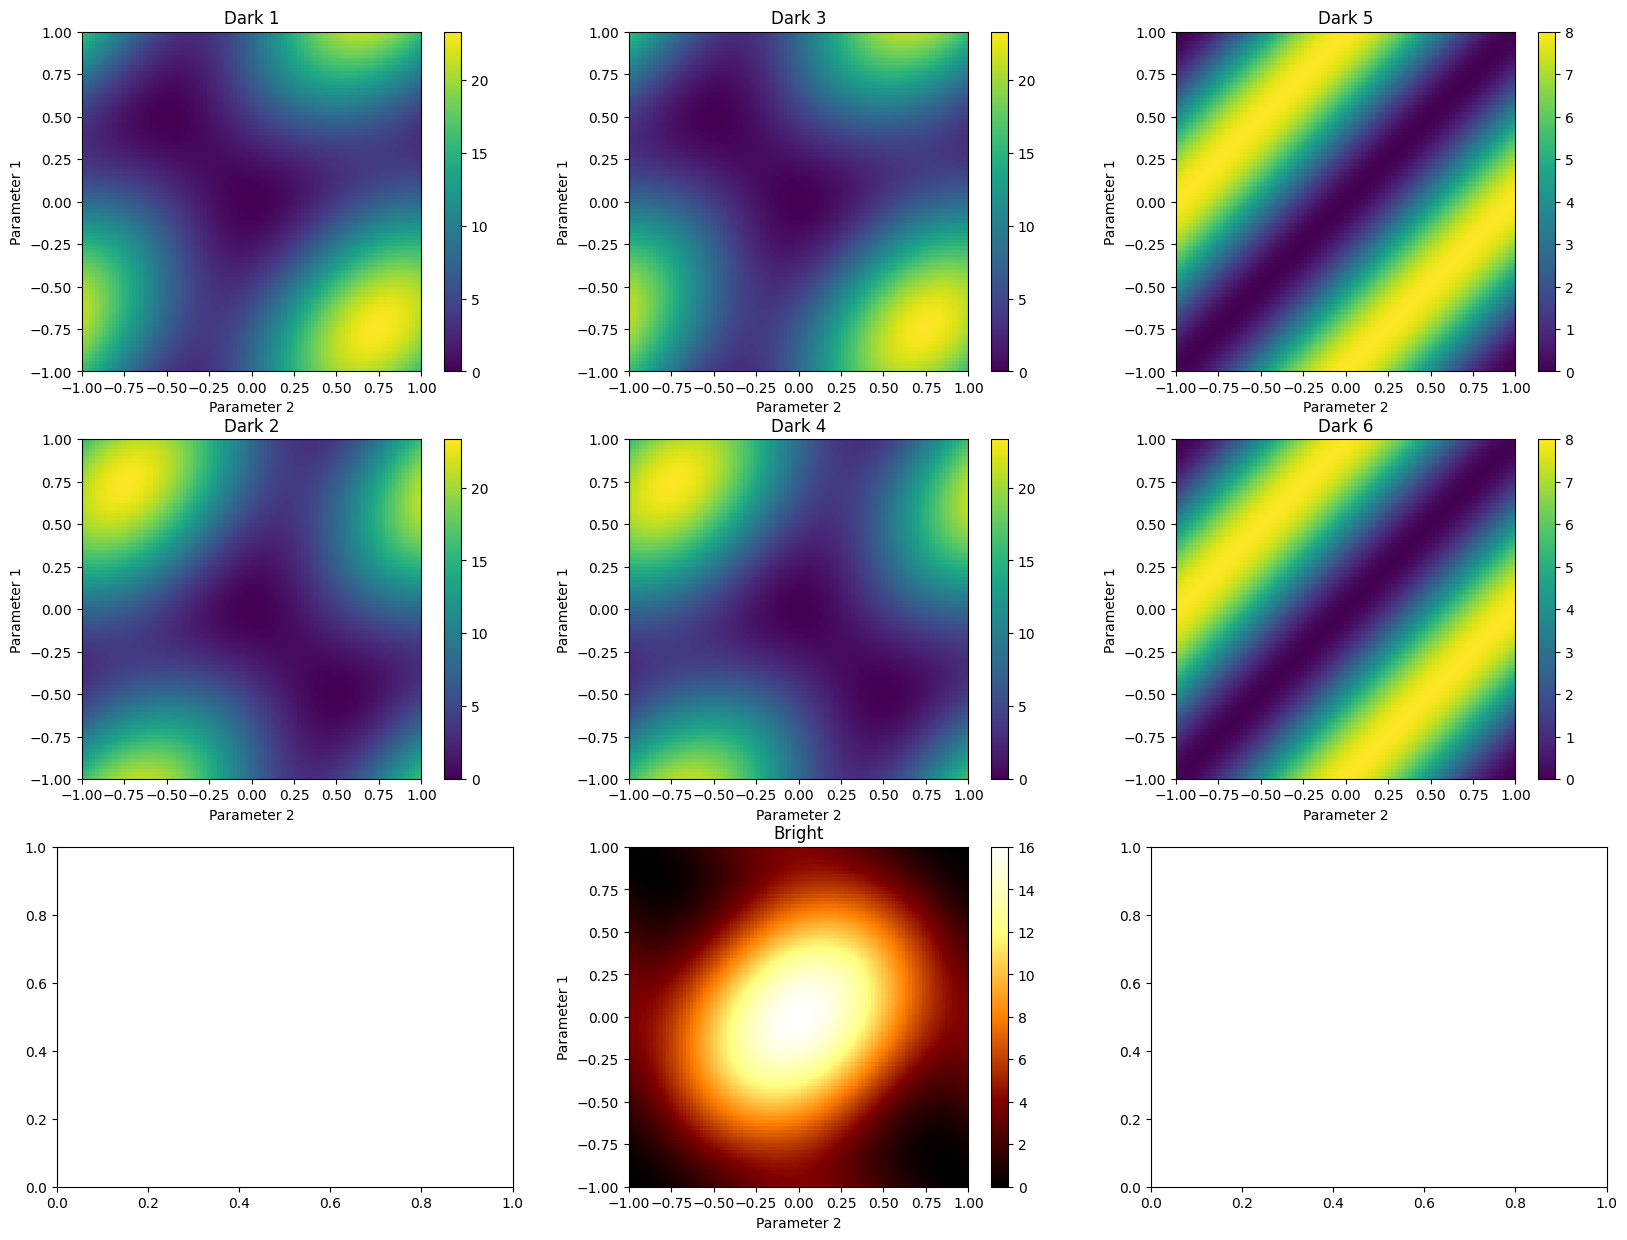

In [4]:
def scan():
    
    scan_on_parameters = (1,2) # Select 2 values from 1 to 14

    # Scan shift power parameter space
    scan = np.linspace(-1, 1, 101)
    null_depths = np.zeros((6, len(scan), len(scan)))
    brights = np.zeros((len(scan), len(scan)))
    fig, axs = plt.subplots(3,3, figsize=(20,15))

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            parameters = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            parameters[scan_on_parameters[0]-1] = scan1
            parameters[scan_on_parameters[1]-1] = scan2
            bright, darks, _ = kn0(star_light, parameters)
            for k, dark in enumerate(darks):
                null_depths[k,i,j] = np.abs(dark)**2 # np.log(np.abs(dark)**2 / np.abs(bright)**2)
                brights[i,j] = np.abs(bright)**2

    for k in range(6):
        p = axs[k%2, k//2]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(null_depths[k], extent=[-1, 1, -1, 1])
        p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
        p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
        plt.colorbar(im)

    p = axs[2,1]
    p.set_title(f"Bright")
    im = p.imshow(brights, extent=[-1, 1, -1, 1], cmap="afmhot")
    p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
    p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
    plt.colorbar(im)
    
    plt.show()

scan()